RMSE: 136.761


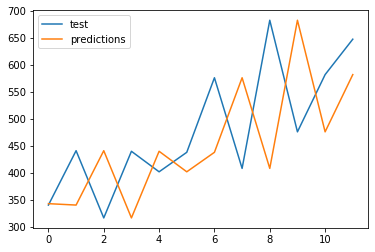

In [17]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# line plot of observed vs predicted
pyplot.plot(test, label='test')
pyplot.plot(predictions, label='predictions')
pyplot.legend()
pyplot.show()


Il modello LSTM in Keras assume che i dati siano divisi per componenti INPUT(X) e OUTPUT(Y). <br>
E' possibile farlo usando la funzione shift() in Pandas che shifterà tutti i valori per un valore predefinito. A noi serve shiftare tutto di 1.<br>
Possiamo contatenare queste due serie insieme per creare un DataFrame pronto per il Supervised Learning. Il primo valore della serie shitftata avrà come valore NaN, possiamo rimpiazzarlo con 0.

In [8]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [18]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())


       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


Il dataset attuale non è stazionario, infatti la sua struttura dipende dal tempo: possiamo notare un tren crescente nei dati.<br>
Questo trend può essere rimosso dalle osservazioni, e poi ri-aggiunto più tardi nelle predizioni per calcolare l'errore.<br>
Un metodo standard per rimuovere i trend è la differenziazione. Cioè sotrarre dal valore del time step corrente quello precedente. Così otteniamo una serie di difference.<br>
Possiamo ottenerlo automaticamente usando la funzione diff() di Pandas.

In [19]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [20]:
 #invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

Adesso possiamo testare le funzioni appena implementate sul dataset completo.

In [21]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


Come gli altri NN, anche LSTM-NN si aspetta dei valori di input entro dei range per le funzioni di attivazione.<br>
La funzione di attivazione di default è l'hyperbolic tangent (tanh), di cui output è compreso tra -1 e 1. Questo è il range preferibile per i valori della serie temporale.<br>
Per rendere equo l'esperimento, i valori dei coefficienti di scala (min e max) devono essere calcolati sul set di dati di addestramento e applicati per ridimensionare il set di dati di test e tutte le previsioni. Questo per evitare di contaminare l'esperimento con le conoscenze del set di dati di test, che potrebbe dare al modello un piccolo vantaggio.<br>
Possiamo portare il dataset in range [-1, 1] usando la classe MinMaxScaler. Come le caltre classi di scikit-learner ha bisogno di dati sotto forma di matrici righe-colonne. Quindi dobbiamo fare un re-shape dei nostri array numpy.
Abbiamo bisogno anche di una funzione che ritorni i valori scalati nella forma originale per poter calcolare gli errori. Mettendo le cose insieme otteniamo il seguente script.

In [23]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())

# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())

# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


## Sviluppo del modello LSTM
Il pro di questo modello è che può imparare lunghe sequenze senza dover dipendere da finestre temporali pre-specificate.<br>
In Keras viene definito come stateful, e implicca il settaggio del parametro 'stateful=True' quando si definisce un layer LSTM.<br>
Di default un layer LSTM in Keras mantiene lo stato tra i dati in un batch. Un batch è un numero di righe del training-set a dimensione fissa che definisce come e quanti feature processare prima dell'aggiornamento dei pesi. <br>
Il layer LSTM si aspetta come input una matrice di dimensioni [samples, time-steps, features]:<br>
- samples: sono le osservazioni, tipicamente le righe del dataset.<br>
- time-steps: sono i tempi i cui vengono rileari le variabili di una osservazione <br>
- features: sono le variabili misurare ai vari tempi di osservazione.<br>

In questo tutoria viene utilizzato:
- Batch Size: 1
- Epochs: 1500
- Neurons: 1


In [24]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    
    # X=input, y=output
    # devono essere ri-shapati in forma samples/time-steps/features
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Usando le SEQUENTIAL KERAS API per definire il network, con le seguenti righe creiamo e compiliamo il network
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Il seguente ciclo adatta manualmente il network ai training-data
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

    return model

# Previsioni con LSTM
Una volta che il modello LSTM è stato fittato al training_set può essere utilizzato per fare predizioni.<br>
Le predizioni possono essere fatte in modi differenti:
- Modalità fissa: fittare tutto il training-set e fare le predizioni su tutto il test-set 
- Modalità dinamica: ri-fittare il modello o aggiornare il modello ad ogni time-step del test-set come nuove osservazioni.
Il secondo metodo ovviamente dovrebbe dare risultati migliori, ma per semplicità in questo tutorial verrà mostrato il primo metodo.<br>
Per fare le predzioni possiamo chiamare la funzione predict(): bisogna passare in input un 3D-Numpy-Array. In questo caso sarà un array di un valore, cioè l'osservazione del tempo precedente.<br>
predict() ritorna un a array di predizioni, uno per ogni riga di input fornito. Fornendo un singolo input, come output otterremo un 2D-numpy-array con un valore.<br>
Possiamo catturare questo behaviour con la nostra funzion       : dato un fit-model una batch-size utilizzata per allenare il modello (es.1), e una riga del test-set, la funzione ritornerà la predizione come un singolo valore floating point.

In [25]:
def forecast(model, batch_size, row):
	X = row[0:-1]
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# Esempio Completo di LSTM
Riassumendo tutti i punti precedenti:
- Caricare i file da CSV.
- Trasformare i dati in modo da renderli compatibili col modello LSTM:
        - Transforming the data to a supervised learning problem.
        - Transforming the data to be stationary.
        - Transforming the data so that it has the scale -1 to 1.
- Fittare LSTM network model con i training data.
- Valutare LSTM model con i test data.
- Report delle performance delle predizioni.


C:\Users\Kraing\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


Month=1, Predicted=279.369221, Expected=339.700000
Month=2, Predicted=369.033121, Expected=440.400000
Month=3, Predicted=351.296270, Expected=315.900000
Month=4, Predicted=400.622232, Expected=439.300000
Month=5, Predicted=357.009609, Expected=401.300000
Month=6, Predicted=449.504217, Expected=437.400000
Month=7, Predicted=408.722569, Expected=575.500000
Month=8, Predicted=435.900595, Expected=407.600000
Month=9, Predicted=477.456007, Expected=682.000000
Month=10, Predicted=528.256872, Expected=475.300000
Month=11, Predicted=457.296297, Expected=581.300000
Month=12, Predicted=484.872890, Expected=646.900000
Test RMSE: 103.472


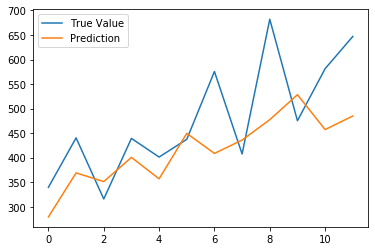

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:], label='True Value')
pyplot.plot(predictions, label='Prediction')
pyplot.legend()
pyplot.show()